# Import

In [1]:
import configparser as cp
import pandas as pd
import numpy as np
from ast import literal_eval

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [67]:
config = cp.RawConfigParser()
config.read(r'config.txt')

proc_file = config.get('main', 'proc_file')
proc_output = config.get('liwc', 'proc_output')
politness_label_output = config.get('analysis', 'politness_label_output')
politness_score_output = config.get('analysis', 'politness_score_output')

In [68]:
df_main = pd.read_csv(
    proc_file, 
    usecols=['Row ID', 'speaker', 'date', 'week', 'text', 'listeners'],
    index_col='Row ID')

# Results

In [69]:
# Read predicted politeness labesl and scores
def read_lst(file):
    lst = []
    with open(file, 'r') as f:
        for line in f: 
            newline = line.strip()
            newline = float(newline)
            lst.append(newline)
    return lst

pol_label_lst = read_lst(politness_label_output)
pol_score_lst = read_lst(politness_score_output)

df_main['pol_label'] = pol_label_lst
df_main['pol_score'] = pol_score_lst

pol_dct = {1: 'polite', 0: 'impolite'}
def get_pol_label(label):
    return pol_dct[label]

df_main['pol_label'] = df_main['pol_label'].apply(get_pol_label)

In [70]:
# Get sentiment labels and scores
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
senti_clf = SentimentIntensityAnalyzer()

def get_sen_label(text):
    senti_dct = senti_clf.polarity_scores(text)
    if senti_dct['compound'] >= 0.05:
        senti = 'pos'
    elif senti_dct['compound'] <= -0.05:
        senti = 'neg'
    else:
        senti = 'neu'
    return senti

def get_get_sen_score(text):
    return senti_clf.polarity_scores(text)['compound']

df_main['sen_label'] = df_main['text'].apply(get_sen_label)
df_main['sen_score'] = df_main['text'].apply(get_get_sen_score)

from sklearn.preprocessing import minmax_scale
df_main['sen_score'] = minmax_scale(df_main['sen_score'].tolist())

In [71]:
# Explode
df_main_explode = df_main.loc[df_main['listeners'].notnull()]
df_main_explode['listeners'] = df_main_explode['listeners'].apply(literal_eval)
df_main_explode = df_main_explode.explode('listeners')
df_main_explode = df_main_explode.set_index('week')
df_main = df_main.set_index('week')

/var/folders/8c/s7c_mn8d05q5mk1frz6_nld80000gn/T/ipykernel_14634/1392628207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main_explode['listeners'] = df_main_explode['listeners'].apply(literal_eval)


In [91]:
# Save
df_main.to_csv('results/processed_with_scores.csv')

# Visualize

In [23]:
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 100

### Sentiment pie chart

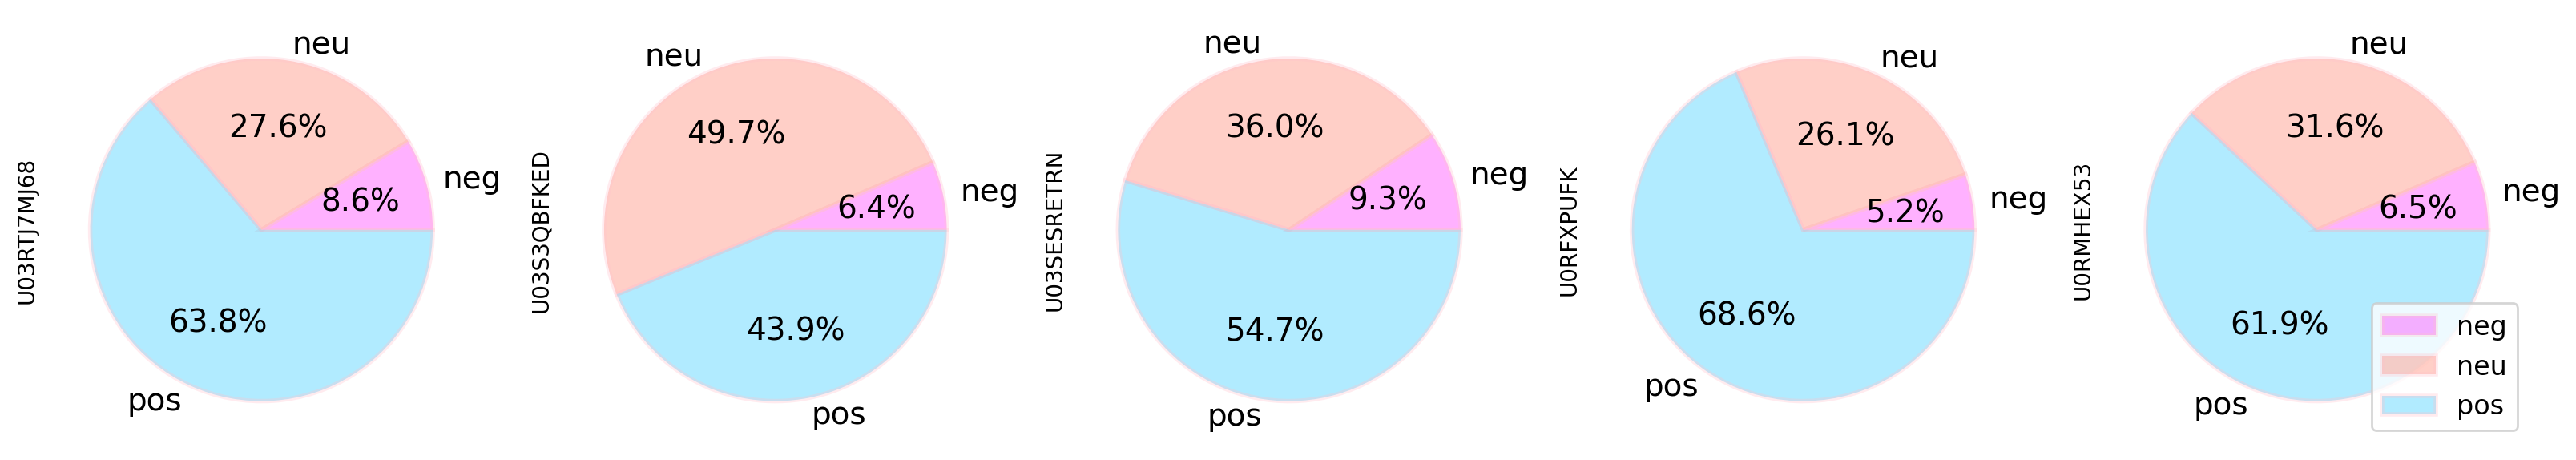

In [85]:
df_sen = df_main.groupby(['speaker', 'sen_label']).size().to_frame().reset_index()
df_sen = df_sen.rename(columns={0: 'count'}).sort_values(by='sen_label')
df_sen = df_sen.pivot(index='sen_label', columns='speaker', values='count')

wedgeprops={'edgecolor':'pink','linewidth': 2, 'antialiased': True, 'alpha':0.3}
textprops={'fontsize': 14}

ax = df_sen.plot(
    kind='pie', subplots=True, figsize=(20,10), legend=None,
    autopct='%1.1f%%', startangle=0, 
    colors=['magenta', 'tomato', 'deepskyblue'],
    wedgeprops=wedgeprops,
    textprops=textprops)

plt.legend(loc='lower right', prop={'size': 12})
plt.savefig('visual/sentiment_distribution.pdf')

### Politeness pie chart

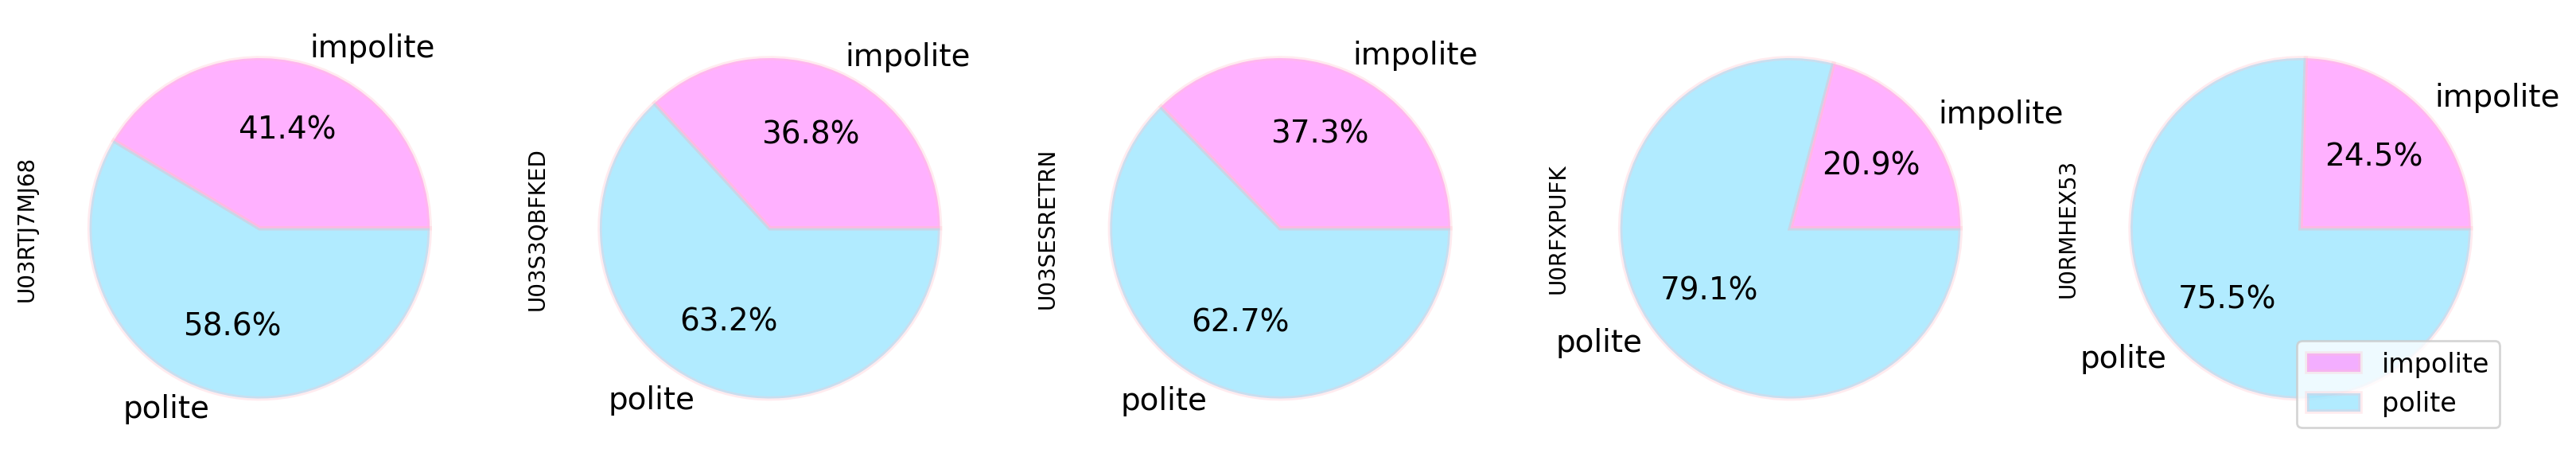

In [86]:
df_pol = df_main.groupby(['speaker', 'pol_label']).size().to_frame().reset_index()
df_pol = df_pol.rename(columns={0: 'count'}).sort_values(by='pol_label')
df_pol = df_pol.pivot(index='pol_label', columns='speaker', values='count')

wedgeprops={'edgecolor':'pink','linewidth': 2, 'antialiased': True, 'alpha':0.3}
textprops={'fontsize': 14}

ax = df_pol.plot(
    kind='pie', subplots=True, legend=None, figsize=(20,10),
    autopct='%1.1f%%', startangle=0, 
    colors=['magenta', 'deepskyblue'],
    wedgeprops=wedgeprops,
    textprops=textprops)

plt.legend(loc='lower right', prop={'size': 12})
plt.savefig('visual/politeness_distribution.pdf')

### Temporal patterns

In [26]:
style_lst = ['*--', '.--', 'x-', '+-', '.-', '^-', 'v-']

In [78]:
speaker_lst = list(set(df_main.speaker))
week_lst = sorted(list(set(df_main.index)))

start = week_lst[-8] # plor only recent patterns
df_tmp = df_main[df_main.index > start]
df_tmp_explode = df_main_explode[df_main_explode.index > start]

In [79]:
def draw_weekly(speaker, score):
    df1 = df_tmp.loc[df_tmp['speaker'] == speaker].groupby(['week'])[[score]].mean()
    ax = df1.plot(style='d:', color='k', linewidth=0.3)

    df2 = df_tmp_explode.loc[df_tmp_explode['speaker'] == speaker].groupby(['week', 'listeners'])[[score]].mean()
    df2 = df2.reset_index().set_index('week')
    df2.groupby('listeners')[score].plot(ax=ax, style='*-', linewidth=0.3, legend=True)
    
    ax.set_xlim(328.5, 334.5)
    ax.set_ylim(0, 1)
    ax.set_title(speaker)
    
    return ax.get_figure()

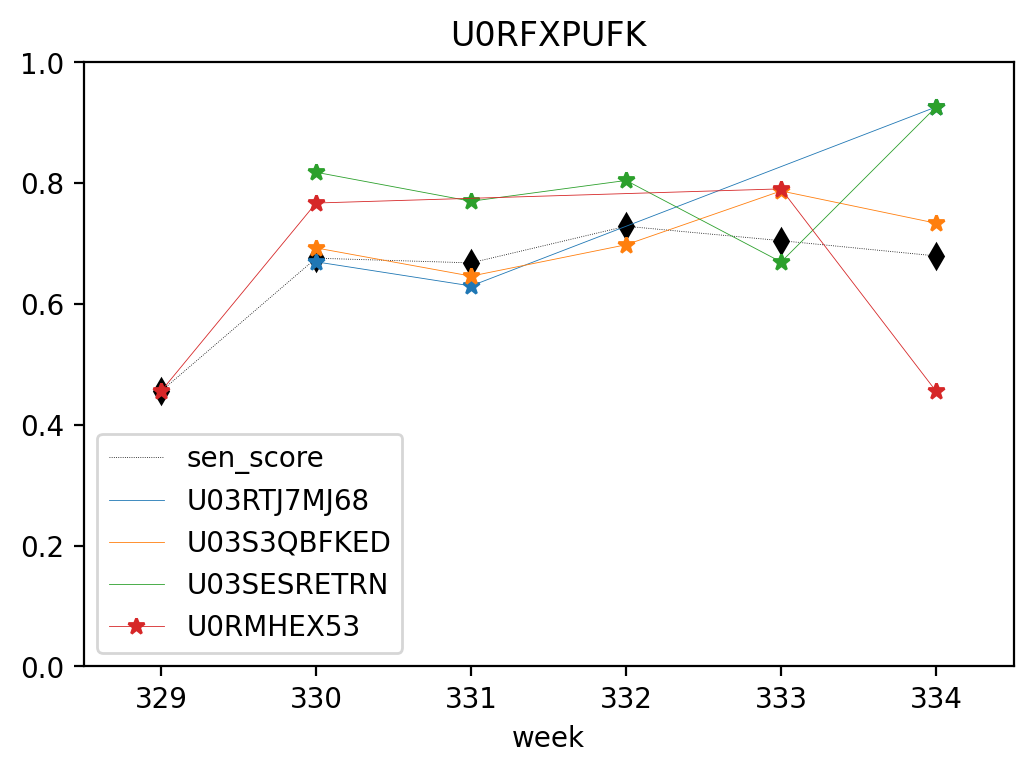

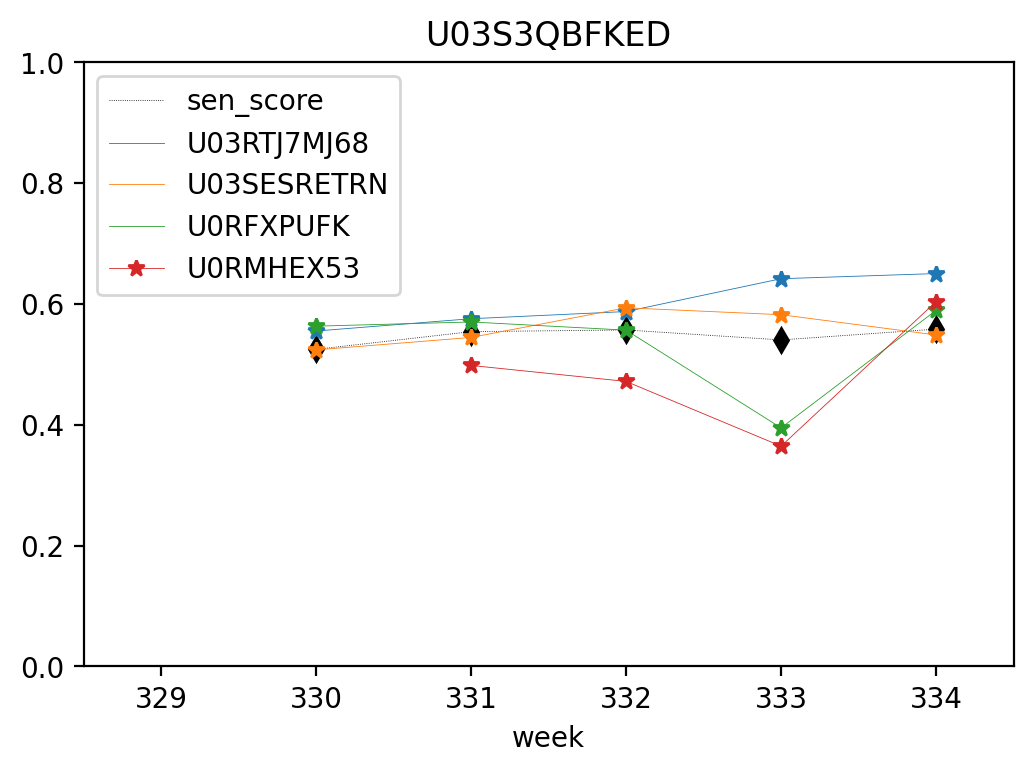

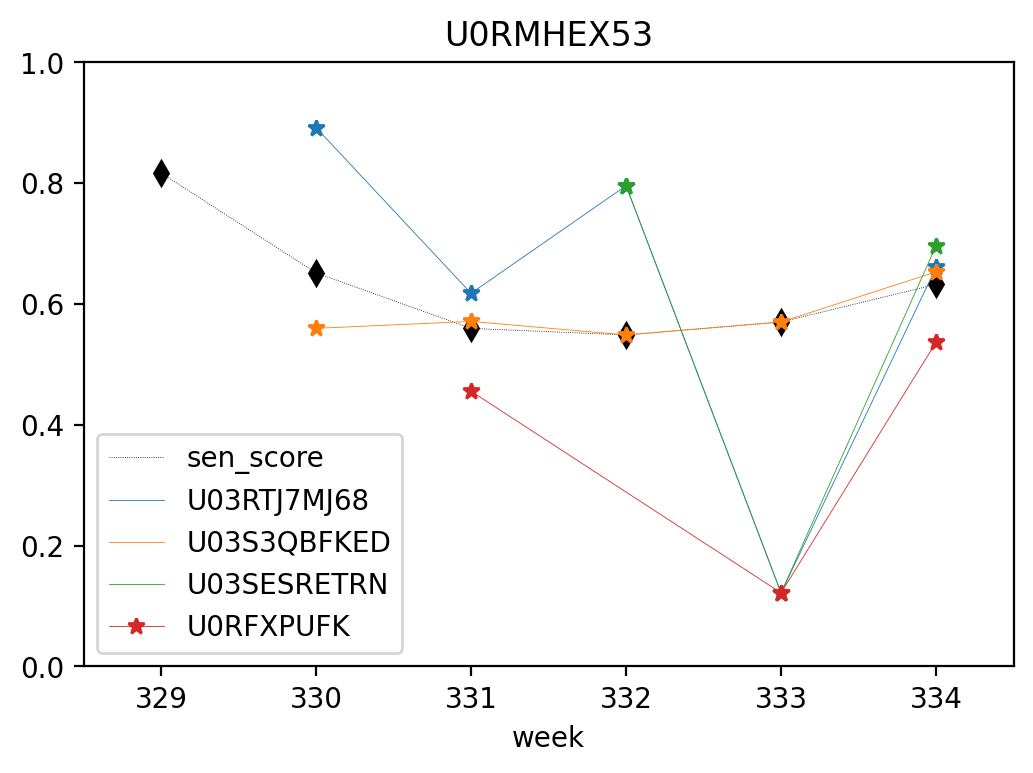

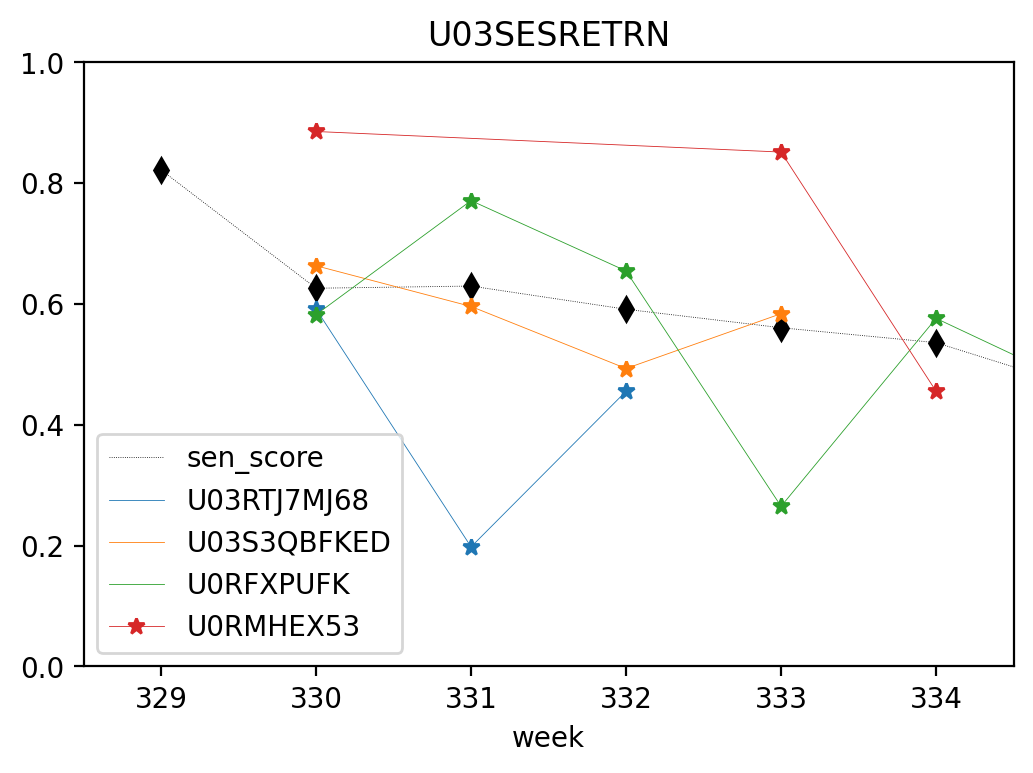

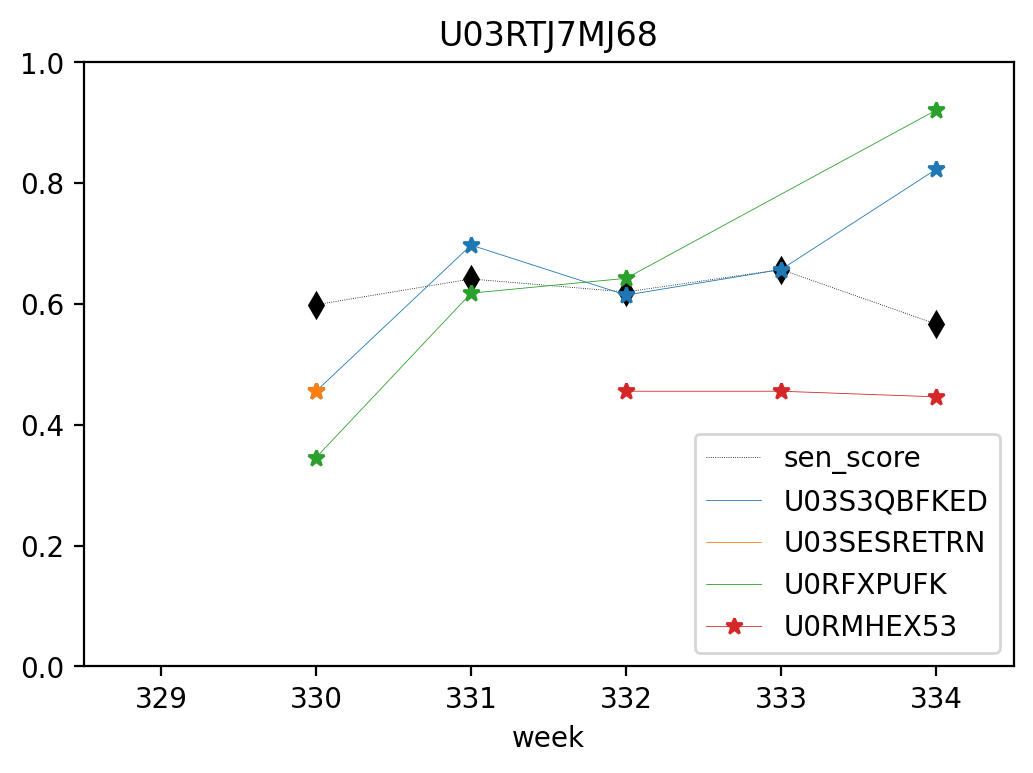

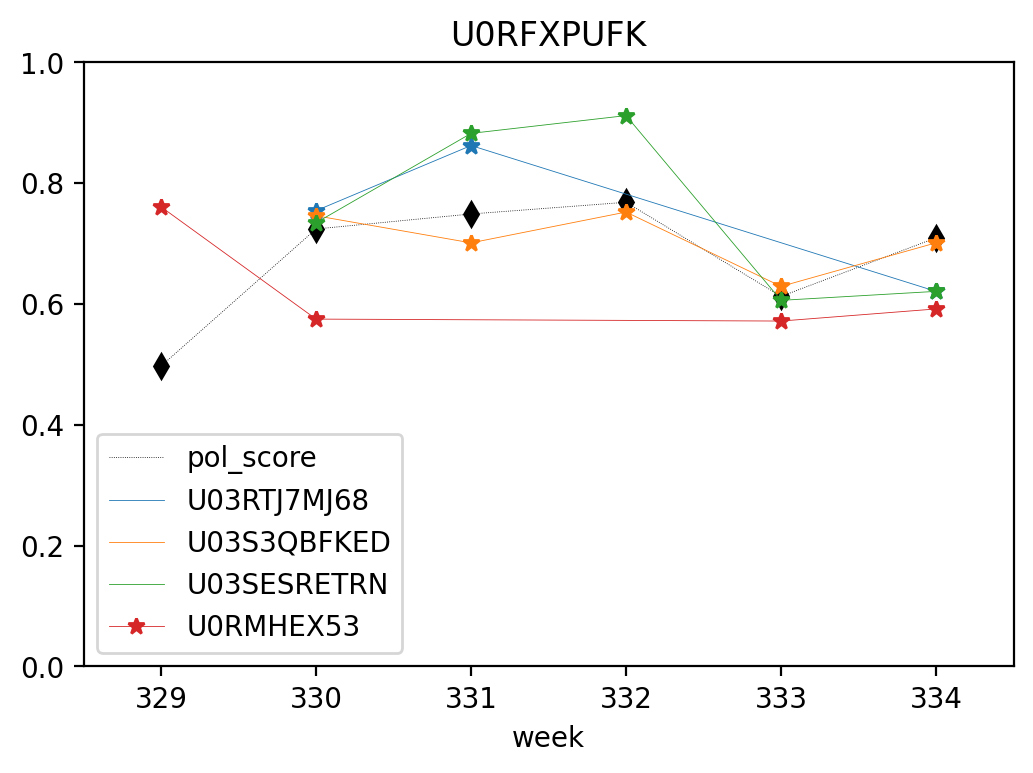

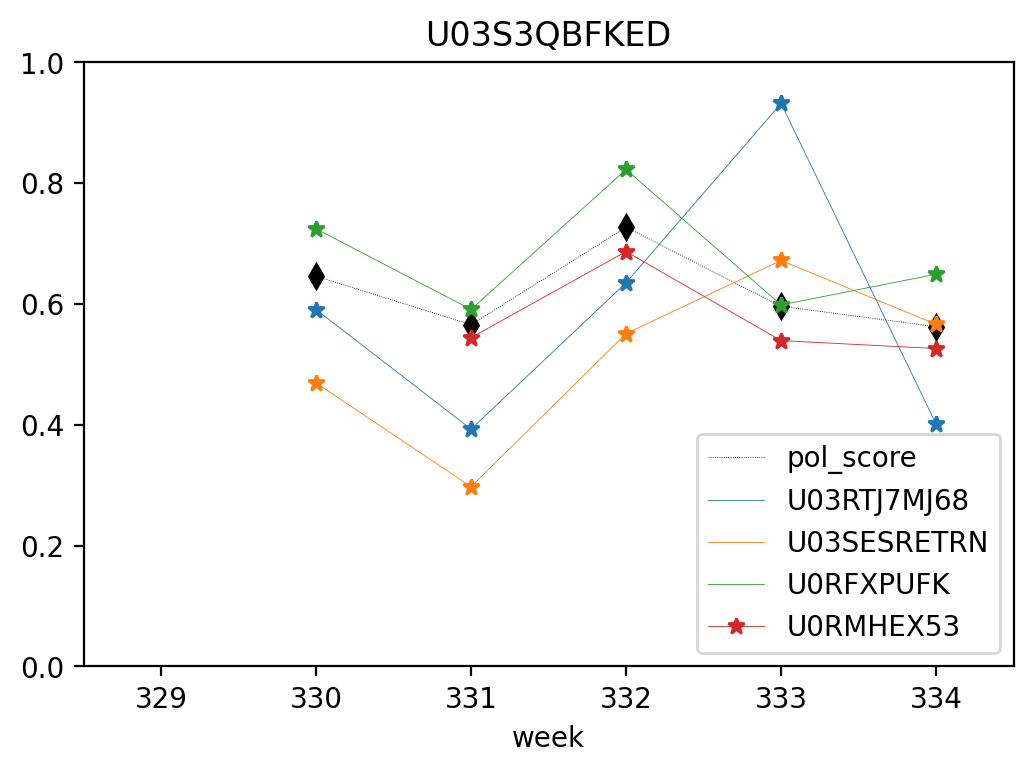

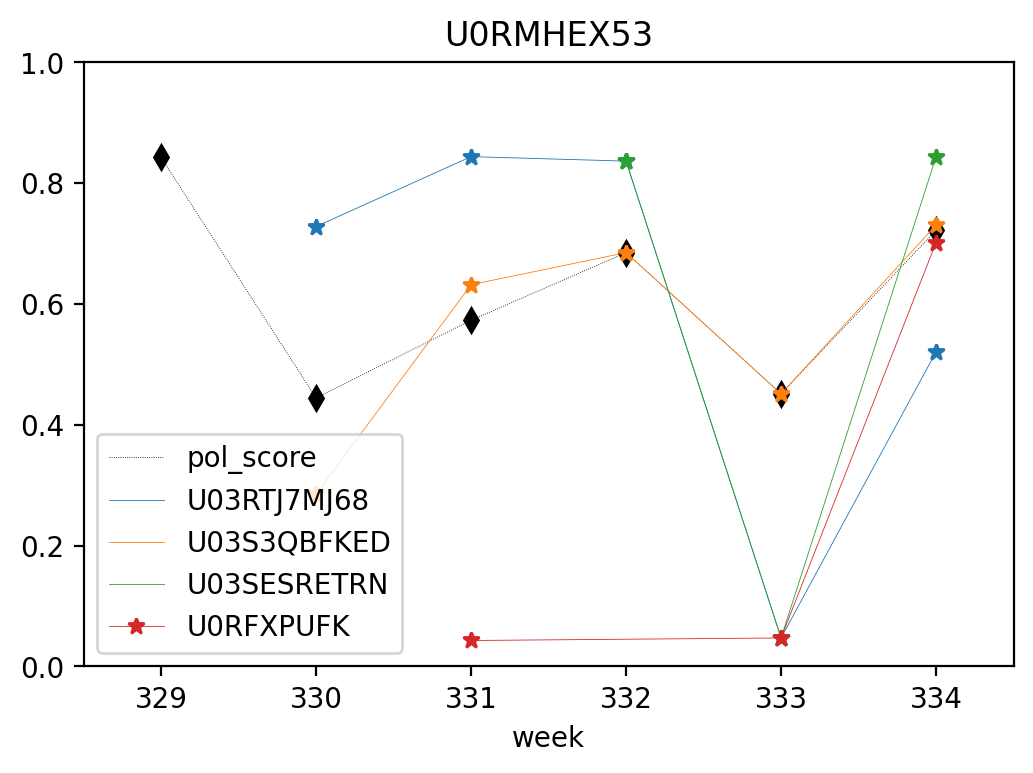

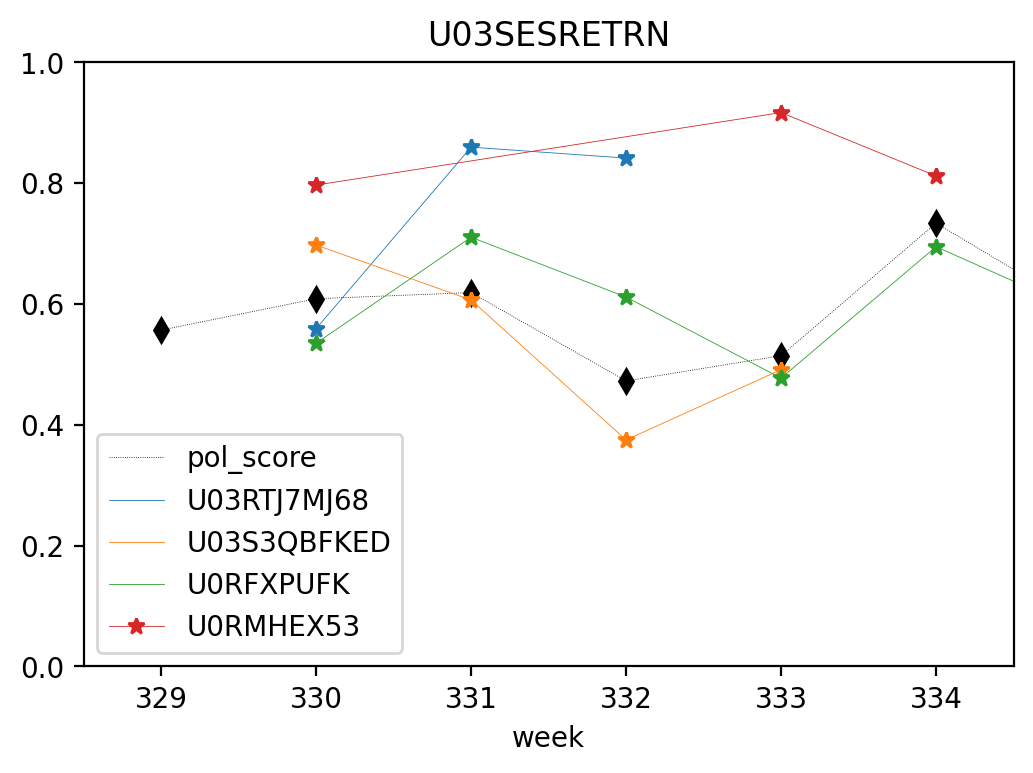

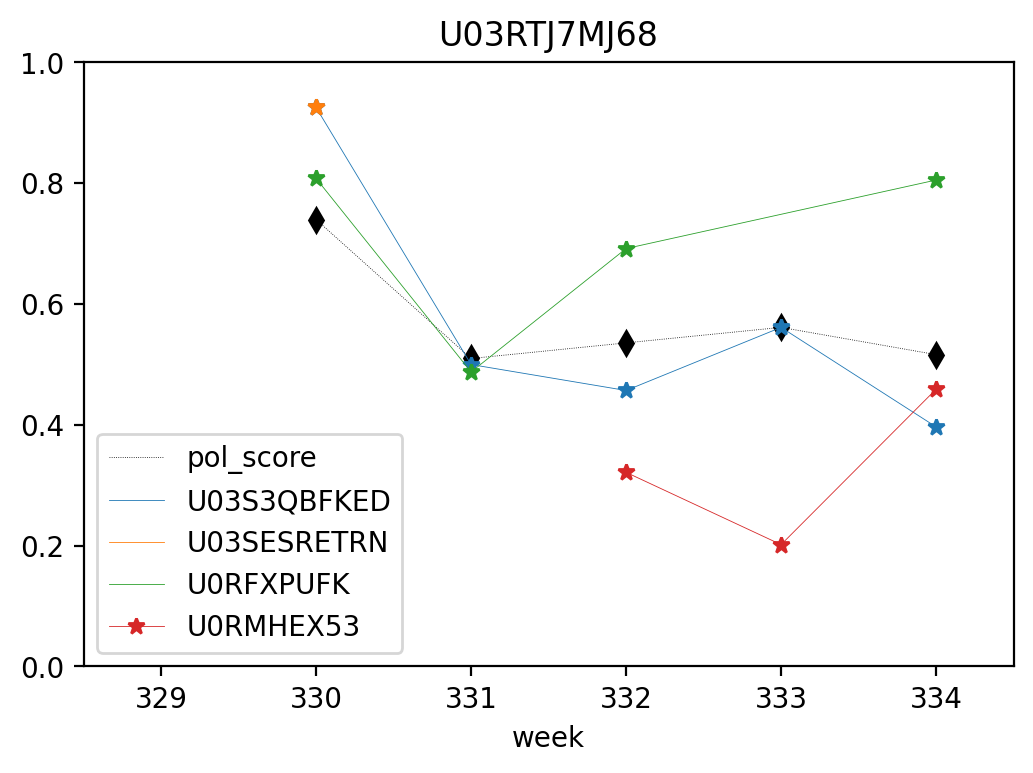

In [89]:
for speaker in speaker_lst:
    draw_weekly(speaker, 'sen_score').savefig('visual/weekly_sentiment_' + speaker + '.pdf')
    
for speaker in speaker_lst:
    draw_weekly(speaker, 'pol_score').savefig('visual/weekly_politeness_' + speaker + '.pdf')

In [2]:
################################################################################
##################################### END ######################################
################################################################################